In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [24]:
data = pl.read_csv("Ice Cream Sales - temperatures.csv")
data

Temperature,Ice Cream Profits
i64,f64
39,13.17
40,11.88
41,18.82
42,18.65
43,17.02
…,…
99,85.13
99,87.08
99,89.29


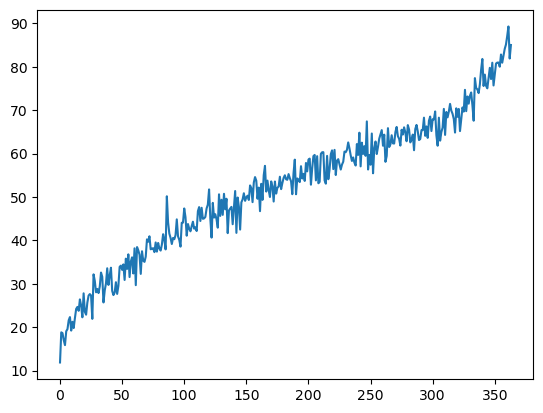

In [60]:
plt.plot(data['Ice Cream Profits'])

In [32]:
data=data[1:].with_columns(pl.Series(data['Ice Cream Profits'][1:]-data['Ice Cream Profits'][:-1]).alias('lag1'))

In [33]:
data

Temperature,Ice Cream Profits,lag1
i64,f64,f64
40,11.88,-1.29
41,18.82,6.94
42,18.65,-0.17
43,17.02,-1.63
43,15.88,-1.14
…,…,…
99,85.13,1.01
99,87.08,1.95
99,89.29,2.21


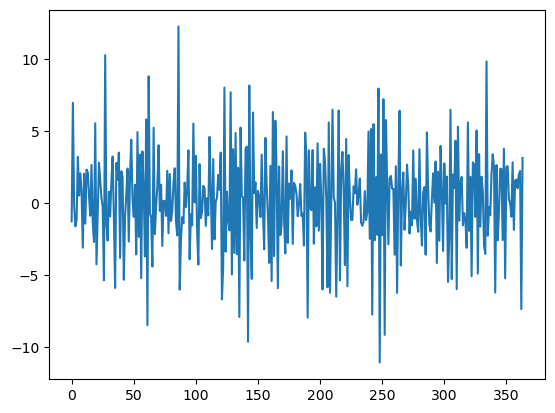

In [34]:
plt.plot(data["lag1"])

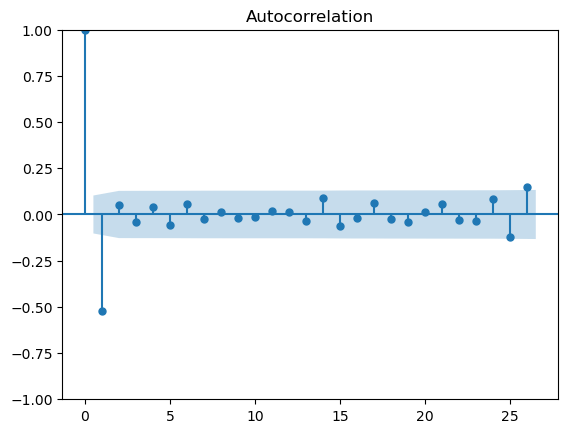

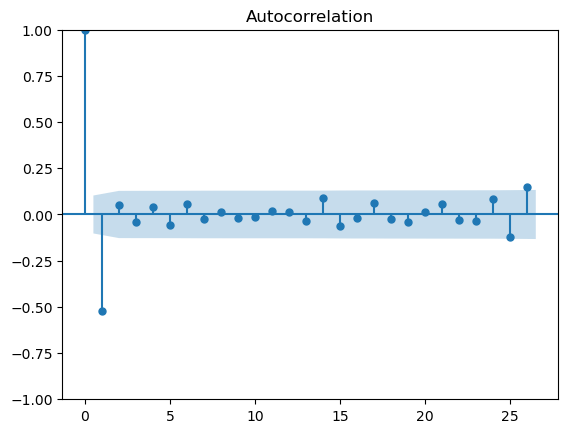

In [42]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x=data['lag1'])

In [63]:
train_data = data.filter(data['Temperature']<90)
test_data = data.filter(data['Temperature']>90)
train_data.shape,test_data.shape

((332, 3), (25, 3))

In [65]:
model = ARIMA(train_data['lag1'].to_pandas(),order=(0,0,1))
model_fit  = model.fit()

In [66]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   lag1   No. Observations:                  332
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -789.572
Date:                Tue, 18 Jun 2024   AIC                           1585.144
Time:                        17:53:59   BIC                           1596.559
Sample:                             0   HQIC                          1589.696
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1663      0.022      7.734      0.000       0.124       0.208
ma.L1         -0.8533      0.032    -26.950      0.000      -0.915      -0.791
sigma2         6.7846      0.501     13.543      0.000       5.803       7.766
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.40   Prob(JB):                         0.44
Heteroskedasticity (H):               0.85   Skew:                            -0.13
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
pred=model_fit.predict(start=90,end=101)

In [71]:
pred-test_data['Ice Cream Profits']

ValueError: operands could not be broadcast together with shapes (12,) (25,) (25,) 

ADF Statistic: -0.5805190664540797
p-value: 0.8753234412046832
ADF Statistic: -8.333688724050507
p-value: 3.3159828439660433e-13


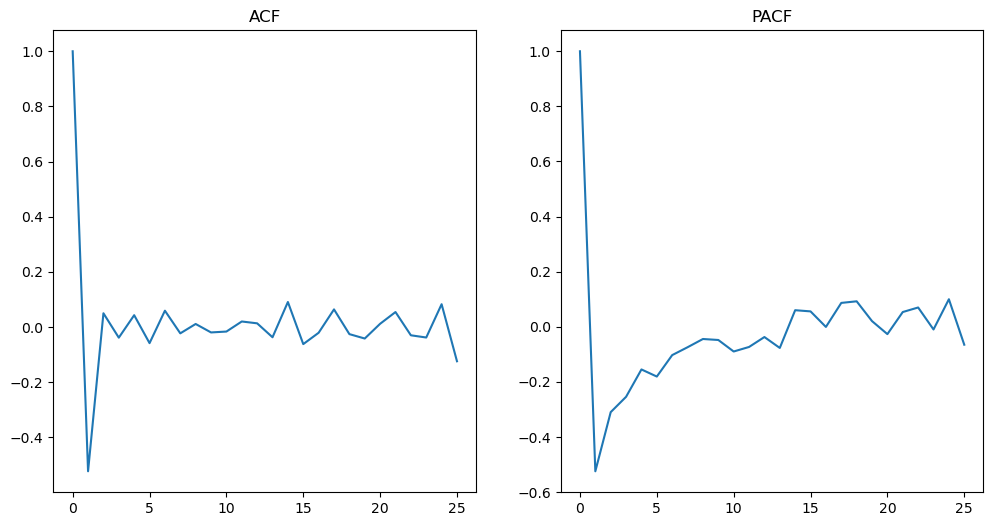

c:\Users\chavv\anaconda\envs\eda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:      Ice Cream Profits   No. Observations:                  330
Model:                ARIMA(0, 0, 50)   Log Likelihood                -784.297
Date:                Tue, 18 Jun 2024   AIC                           1672.594
Time:                        18:08:14   BIC                           1870.147
Sample:                             0   HQIC                          1751.395
                                - 330                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.2683      3.284     15.005      0.000      42.833      55.704
ma.L1          0.2450      0.111      2.211      0.027       0.028       0.462
ma.L2          0.3450      0.125      2.770      0.0

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

# Load data
data = pd.read_csv("Ice Cream Sales - temperatures.csv")

# Check for stationarity
result = adfuller(data['Ice Cream Profits'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If non-stationary, difference the series and test again
data['Diff'] = data['Ice Cream Profits'].diff().dropna()
result = adfuller(data['Diff'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF
acf_vals = acf(data['Diff'].dropna())
pacf_vals = pacf(data['Diff'].dropna())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_vals)
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf_vals)
plt.title('PACF')
plt.show()

# Fit ARMA model (adjust p and q based on ACF and PACF)
model = ARIMA(data['Ice Cream Profits'][:330], order=(0, 0, 50))
fit = model.fit()

# Diagnose model
print(fit.summary())

# Forecast
forecast = fit.forecast(steps=10)
print(forecast)


In [100]:
pred=fit.predict(start=330,end=365)

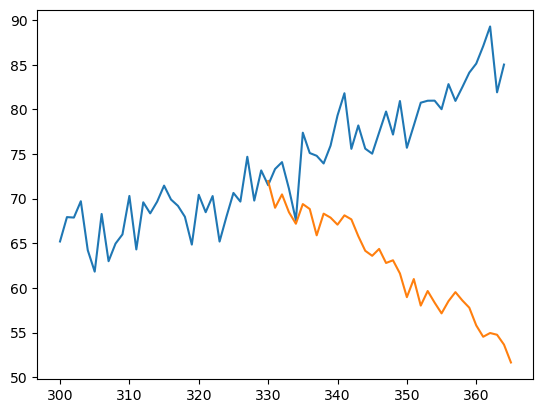

In [101]:
plt.plot(data['Ice Cream Profits'][300:])
plt.plot(pred)